# Info del concurso
* link : https://www.binnario.com/challenge
* slack https://binnario-innspiral.slack.com/

## Descripción

El área de Logística y Supply Chain de Walmart Chile convoca a Data Scientists o empresas afines a participar del desafío de mejorar la asignación de productos a tiendas para una campaña de mercadería general de Walmart Chile, basada en la estimación de demanda de cada producto. Se espera que los participantes entreguen como solución un algoritmo o modelo matemático que sea capaz de disminuir el error entre el valor real y el pronosticado de la venta de cada producto antes de ser liquidado. 

**La asignación de productos a tiendas es un proceso que consiste en definir el número de productos a enviar a cada una de las tiendas de Walmart Chile para un período específico (duración de la campaña)** para: maximizar las ventas al precio definido, evitar los quiebres de stock, minimizar los saldos en tienda al final de la campaña y minimizar los “remates” a un precio inferior al precio de campaña (productos liquidados). 

Se entiende como mercadería general a cualquier producto minorista que no sea alimentos, comestibles o consumibles, por ejemplo, vestuario, electrodomésticos, juguetes, deporte, artículos de cama, entre otros. 

Los participantes deberán entregar sus **predicciones de venta a precio completo (antes de liquidar) para 11 productos en 88 tiendas**, para la campaña de invierno de mercadería general que duró desde el **01 de abril hasta el 18 de julio del 2018**. 

Los datos para este desafío estarán disponibles para descargar en la sección de descarga de datos y considerarán:

- Datos históricos de ventas e inventarios previos a la campaña mencionada.

- Más de 600 SKUs de distintas categorías de productos.

- Se indicarán los 11 SKUs a predecir sus ventas.

### cambios 

1.    Se disponibilizó un nuevo set de datos, los cuales están descritos dentro de la descripción del desafío.

2.    **Se cambiaron los códigos de los SKUs a estimar su demanda, los cuales son 70, 316, 14, 40, 4, 173, 66, 3, 475, 415, 168.**

3.    Se entregó un nuevo formato de entrega de resultados. Notar que no todos los productos se venden en todas las tiendas.




### del slack

- fuera de los datos entregados, quizás calendario, clima, variables macroeconómicas. Esto es parte del desafío.

#### Q1
Acuevas   [24 ene. a la(s) 19:23]
Hola, tengo las siguentes dudas:

1 Dado que hay que predecir la cantidad de ventas antes que se liquiden los productos, si la liquidación ocurre antes del tiempo final de predicción (18/julio), pero aún asi entrego predicciones de venta, esto afecta al puntaje? i.e. debemos indicar cuando entra en liquidación?

2 La predicción de venta tiene que ser necesariamente un número entero? osea puedo predecir 2.4 unidades vendidas?

3 Algunos sku, en algunas tiendas, presentan un inventario igual a cero el día antes del horizonte de prediccion  (31/marzo/2018), podemos asumir que existe inventario mayor a cero desde el primer dia de la promocion (01/abril/2018) o debemos obtener una estimación a partir de los datos?

Binnario   [hace 13 días]
Hola @Acuevas respondo tus preguntas:
1) No deben indicar cuando el producto entra en liquidación. **El modelo debe hacer la predicción del periodo y precio completo  y en la evaluación se filtrará cuáles tienen quiebre y/o liquidación.**

2) Es altamente recomendable entregar la predicción en números enteros ya que esto es lo que más se asemeja a la realidad.

3) Es importante que se desafíen a hacer supuestos. Es correcto hacerlos y tendrán que argumentar su lógica en el momento de evaluación en caso de tener bajo % de error.

#### Q2

cserpell   [28 ene. a la(s) 11:37]
Hola a todos. Una pregunta: ¿Qué significa una venta negativa en la tabla data?
1 respuesta

Scordova   [hace 10 días]
Hola, una venta negativa se puede dar cuando la suma de las notas de créditos es mayor a las vendidas, ejemplo si ayer vendi 1 Pero 2 clientes me devolvieron 1 cada uno la venta del día será -1. Para casos prácticos se debe considerar como 0.

Saludos!


In [1]:
#  %%javascript
#  IPython.OutputArea.prototype._should_scroll = function(lines) {
#      return false;
#  }

In [2]:
import pandas as pd 
import pandas_profiling

import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
pd.options.display.float_format = '{:20,.2f}'.format


### carga data
1_data.csv  2_local.csv  3_item.csv  4_campana.csv  5_Precios_promocionales.csv


In [4]:
data = pd.read_csv("./data/1_data.csv",
                   parse_dates=[0],
                   dtype={'Local':'category','Item':'category'})
local = pd.read_csv("./data/2_local.csv")
                    #dtype={'Local':'category','Grupo':'category'})
item = pd.read_csv("./data/3_item.csv",
                  dtype={'Item':'category'})
campana = pd.read_csv("./data/4_campana.csv",
                     parse_dates=[3,4])
Precios_promocionales = pd.read_csv("./data/5_Precios_promocionales.csv")
          

# revision datos  Raw

## Tabla "Data"

* Fecha (Índice)
* Local (Índice)
* Item (Índice)
* Unidades: Unidades vendidas
* Venta: En valor (p*q) ( precio por cantidad )
* Inventario: Unidades (On_hand)

<span style="color:red"> reeplazar nan por zeros ? 
datos negativos en ventas?</span>

repuesta de organizacion desde slack
: _"Hola, una venta negativa se puede dar cuando la suma de las notas de créditos es mayor a las vendidas, ejemplo si ayer vendi 1 Pero 2 clientes me devolvieron 1 cada uno la venta del día será -1. Para casos prácticos se debe considerar como 0."_


In [5]:
data.head()

,Fecha,Local,Item,Unidades,Venta,Inventario
0,2017-01-07,29,98,2.00,"5,866.00",29.00
1,2017-01-07,29,172,1.00,"3,773.00",247.00
2,2017-01-07,29,240,nan,nan,7.00
3,2017-01-07,29,249,nan,nan,8.00
4,2017-01-07,29,174,nan,nan,18.00


In [6]:
pandas_profiling.ProfileReport(data)


Number of variables,6
Number of observations,4792841
Total Missing (%),24.5%
Total size in memory,160.0 MiB
Average record size in memory,35.0 B
Numeric,3
Categorical,2
Boolean,0
Date,1
Text (Unique),0
Rejected,0


Salta altiro a la vista la gran cantidad de datos nulos ( casi 70% en ventas y unidades). Si uno "submitea" una predicción que solo tenga todos los datos nulos, alcanza altiro 100% error MAPE ;) .

### plots 

Plots de algunos SKUs

## Tabla "Local"

* Local (Índice)
* Región
* Grupo (Tamaño del local: 1 es el más grande a 7 el más pequeño)
* Comuna

In [7]:
local.head(5)

,Local,Comuna,Region,Grupo
0,29,Quilicura,Region Metropolitana,4
1,64,La Pintana,Region Metropolitana,5
2,12,Puerto Montt,Region De Los Lagos,2
3,67,La Florida,Region Metropolitana,4
4,75,Peñalolén,Region Metropolitana,2


la correlacion entre local y grupo no tiene sentido, pero igual se esta mostrando ( por bug en libreria)

In [8]:
pandas_profiling.ProfileReport(local,check_correlation = False) 


Number of variables,4
Number of observations,88
Total Missing (%),0.0%
Total size in memory,2.8 KiB
Average record size in memory,32.9 B
Numeric,2
Categorical,2
Boolean,0
Date,0
Text (Unique),0
Rejected,0


#### Tabla Item

* Item (Índice)
* Capacidad (Cantidad de unidades que caben en una caja)
* L1 (departamento)
* L2 (categoría)
* L3 (subcategoría)
* L4 (fineline)

<span style="color:red"> Que es fineline? </span>


In [9]:
item.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 663 entries, 0 to 662
Data columns (total 6 columns):
Item         663 non-null category
Capacidad    663 non-null int64
L1           663 non-null int64
L2           663 non-null int64
L3           663 non-null int64
L4           663 non-null int64
dtypes: category(1), int64(5)
memory usage: 52.5 KB


In [10]:
pandas_profiling.ProfileReport(item,check_correlation = False)


Number of variables,6
Number of observations,663
Total Missing (%),0.0%
Total size in memory,52.5 KiB
Average record size in memory,81.0 B
Numeric,5
Categorical,0
Boolean,0
Date,0
Text (Unique),1
Rejected,0


# Tabla "Campaña"

* Item (Índice)
* Local (Índice)
* Id_campaña
* Fecha_inicio
* Fecha_termino

In [11]:
campana.head()

,Local,Item,Id_campaña,Fecha_inicio,Fecha_termino
0,10,272,29,2018-01-02,2018-04-06
1,48,173,15,2017-03-23,2017-04-19
2,48,66,11,2017-03-23,2017-07-31
3,19,140,24,2017-07-20,2017-08-31
4,48,91,28,2018-02-05,2018-03-28


In [12]:
campana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31918 entries, 0 to 31917
Data columns (total 5 columns):
Local            31918 non-null int64
Item             31918 non-null int64
Id_campaña       31918 non-null int64
Fecha_inicio     31918 non-null datetime64[ns]
Fecha_termino    31918 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3)
memory usage: 1.2 MB


In [13]:
pandas_profiling.ProfileReport(campana,check_correlation = False)


Number of variables,5
Number of observations,31918
Total Missing (%),0.0%
Total size in memory,1.2 MiB
Average record size in memory,40.0 B
Numeric,3
Categorical,0
Boolean,0
Date,2
Text (Unique),0
Rejected,0


## Tabla "Precios_promocionales": 
Son los precios completos de los productos de los que se debe predecir la venta.

* Item
* Precio Promocional

In [14]:
Precios_promocionales["Item"] = Precios_promocionales["Item;Precio_camp;"].map(  lambda x : x.split(";")[0] )
Precios_promocionales["Precio_camp"] = Precios_promocionales["Item;Precio_camp;"].map(  lambda x : x.split(";")[1] )
Precios_promocionales = Precios_promocionales.drop(["Item;Precio_camp;"],axis=1)

Estos son los items a estimar en las campañas. Los 11 SKUs para los cuales se debe estimar la demanda son los siguientes: 3, 4, 14, 40, 66, 70, 168, 173, 316, 415, 475. Es importante notar que no todos los productos se venden en todas las tiendas.


In [15]:
Precios_promocionales.head(11)

,Item,Precio_camp
0,3,664
1,4,664
2,14,8395
3,40,4193
4,66,9235
5,70,4193
6,168,8395
7,173,5874
8,316,42008
9,415,4193


In [16]:
Precios_promocionales.describe(include='all')

,Item,Precio_camp
count,11,11
unique,11,7
top,173,4193
freq,1,3


In [17]:
Precios_promocionales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
Item           11 non-null object
Precio_camp    11 non-null object
dtypes: object(2)
memory usage: 256.0+ bytes


## Union de datos

Se hacen joins entre las tablas para agruparlas en una sola, se ordenan datos nulos, negativos, e incompletos (nan). Se pueden ver las estadisticas de locales e items relativas a las ventas.

In [18]:
data_new = data
data_new.fillna(value={ "Unidades":0,"Venta":0,"Inventario":0},inplace=True) #, 



join tabla "Local"

In [19]:
for col in ['Local', 'Grupo']:
    local[col] = local[col].astype('category')
    
local['Local'] = local['Local'].astype('int32')
data_new['Local']= data_new['Local'].astype('int32')
data_new = pd.merge(data_new, local, how='left', on = 'Local') #left_on = 'Local', right_on = 'Id'

#data_new.drop(["Local"], axis=1,inplace=True)

data_new.rename(columns={'Grupo': 'Local_grupo'}, inplace=True)
data_new.rename(columns={'Unidades': 'Unidades_venta','Venta':'Monto_venta' }, inplace=True)


renombrado y joins de tabla "items"

In [20]:
item_new = item.rename(columns={'L1': 'Item_departamento'
                                , 'L2': 'Item_categoría'
                                ,'L3': 'Item_subcategoría'
                                , 'L4': 'Item_fineline' 
                                ,'Capacidad': 'Item_capacidad'})

data_new = pd.merge(data_new, item_new, how='left', on = 'Item') #left_on = 'Local', right_on = 'Id'
#data_new.drop(["Item"], axis=1,inplace=True)


### data_new.info()

In [21]:
pandas_profiling.ProfileReport(data_new)


Number of variables,14
Number of observations,4792841
Total Missing (%),0.0%
Total size in memory,498.2 MiB
Average record size in memory,109.0 B
Numeric,9
Categorical,4
Boolean,0
Date,1
Text (Unique),0
Rejected,0


# plots

Se plotean algunos de los skus a predecir (70,44,63,415,173) y, todos para el local 29 ( por elegir alguno).

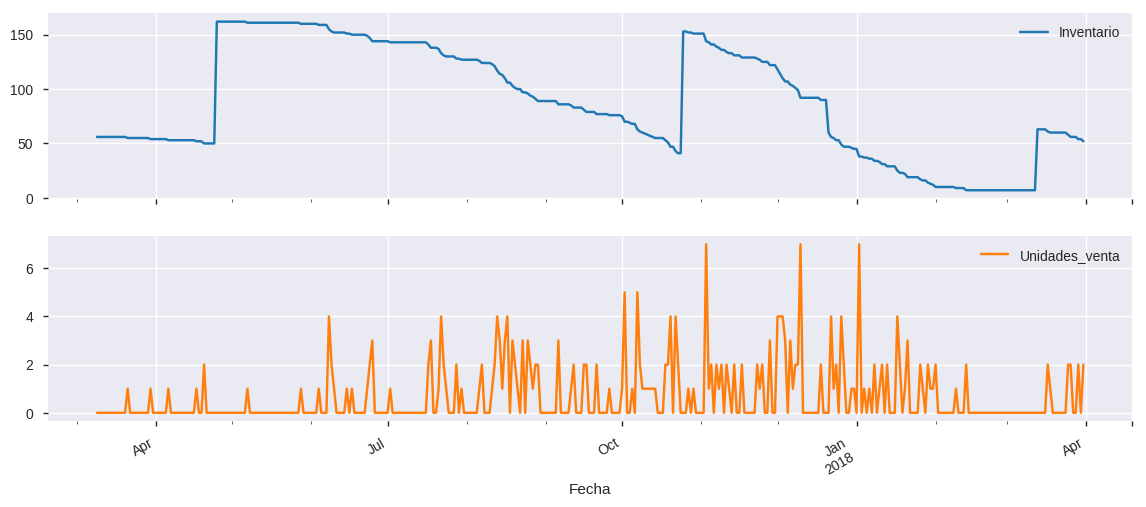

In [22]:
tmp = data_new[ (data_new['Item' ] == '70') & (data_new['Local'] == 29) ][['Inventario','Fecha','Unidades_venta']].set_index('Fecha')
tmp.plot(subplots=True, figsize=(14, 6));

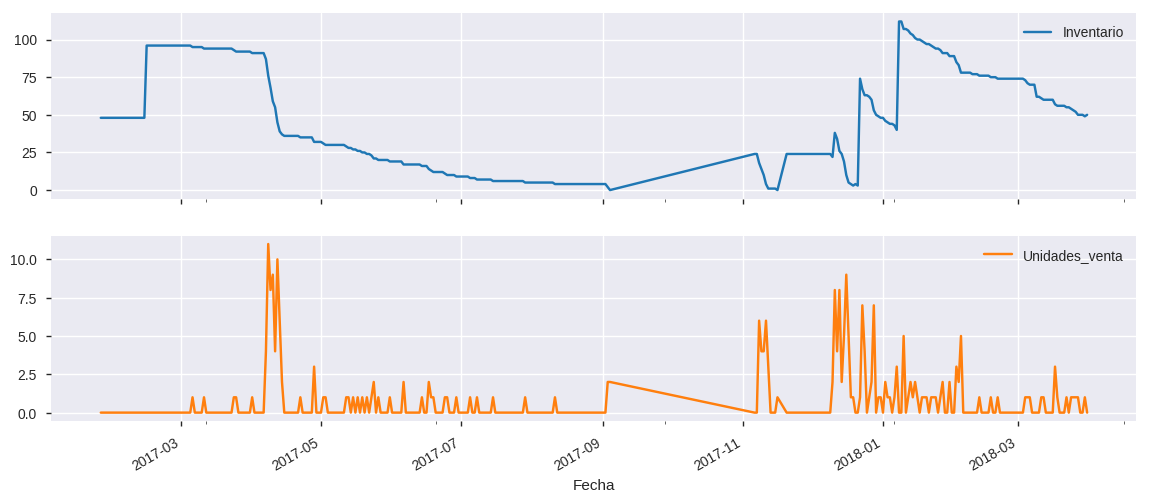

In [23]:
tmp = data_new[ (data_new['Item' ] == '40') & (data_new['Local'] == 29) ][['Inventario','Fecha','Unidades_venta']].set_index('Fecha')
tmp.plot(subplots=True, figsize=(14, 6));

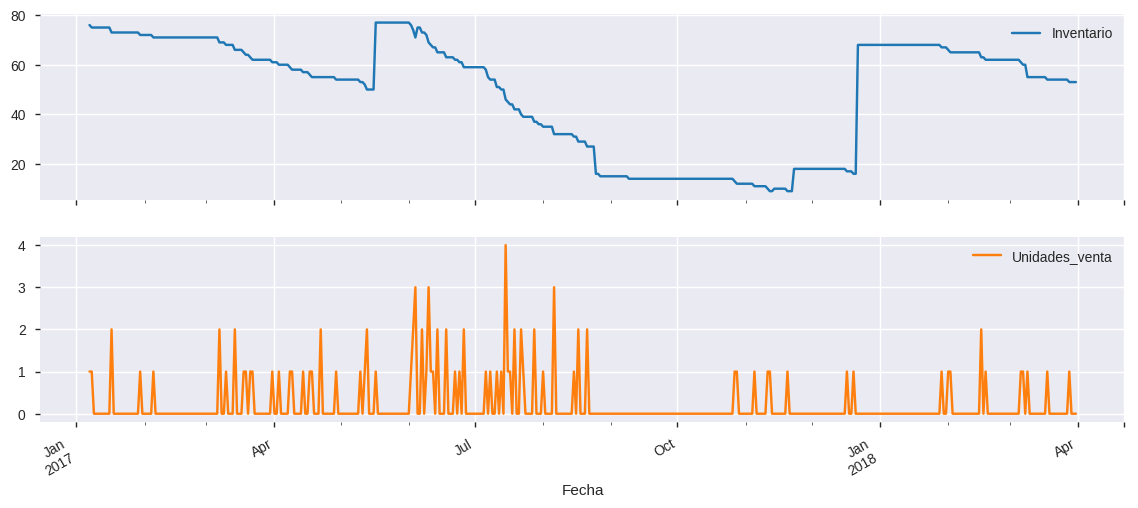

In [24]:
tmp = data_new[ (data_new['Item' ] == '66') & (data_new['Local'] == 29) ][['Inventario','Fecha','Unidades_venta']].set_index('Fecha')
tmp.plot(subplots=True, figsize=(14, 6));

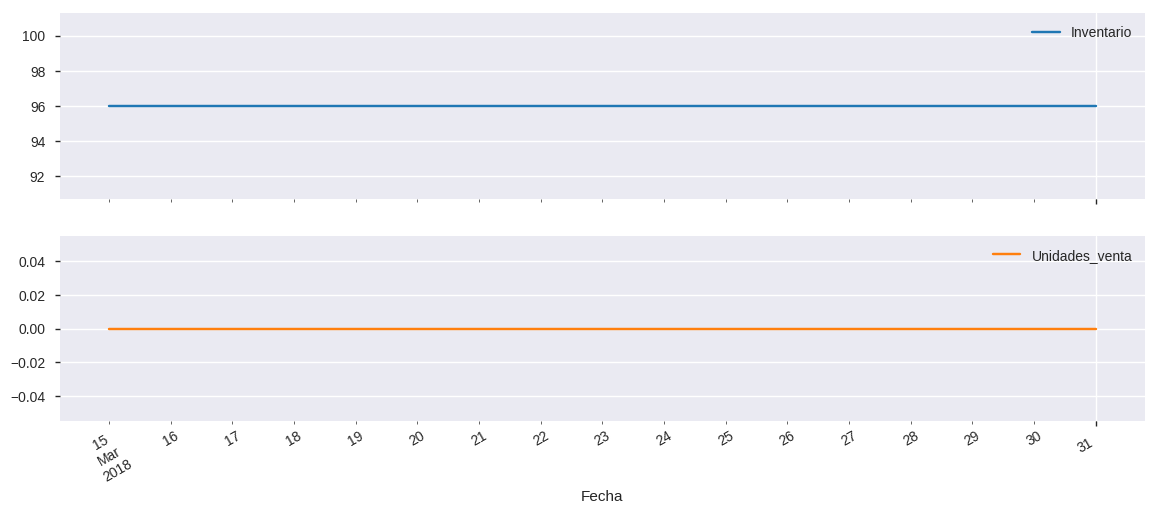

In [25]:
tmp = data_new[ (data_new['Item' ] == '415') & (data_new['Local'] == 29) ][['Inventario','Fecha','Unidades_venta']].set_index('Fecha')
tmp.plot(subplots=True, figsize=(14, 6));

2

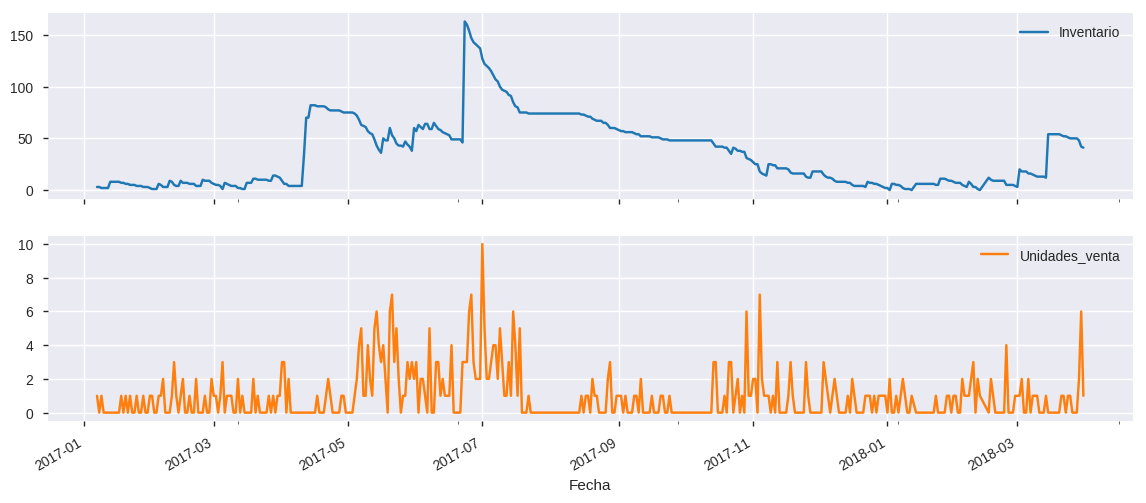

In [26]:

tmp = data_new[ (data_new['Item' ] == '173') & (data_new['Local'] == 29) ][['Inventario','Fecha','Unidades_venta']].set_index('Fecha')
tmp.plot(subplots=True, figsize=(14, 6));2